<font color='#E27271'>

# *Unveiling Complex Interconnections Among Companies through Learned Embeddings*</font>

-----------------------
<font color='#E27271'>

Ethan Moody, Eugene Oon, and Sam Shinde</font>

<font color='#E27271'>

August 2023</font>

-----------------------
<font color='#00AED3'>

# **Model: BERT trained on 10K Corpus (11 Sectors)** </font>
-----------------------

We leverage the BERT model pre-trained on 10K corpus in our prior step for text multiclass classication. As this model is tailor trained on the specific 10K corpus we expect this model to yield better performance than the regular BERT.

We will use this pre-trained model to encode summarized Item 1 ("Business") of SEC 10-K reports using XLNet summarization for companies listed on NYSE and NASDAQ. The goal is to predict the GICS sector mutliclass classification for these companies. We unfroze all layers during training and validation, added two additional hidden layers of 256 neurons, and incorporated a neural dropout rate of 0.20 in between each hidden layer to help prevent overfitting.

**We use all 11 sector's in this case**

# 1 Installs, Imports and Setups

In [ ]:
# Installs
!pip install transformers --quiet
!python -m spacy download en_core_web_lg --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 89.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 121.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.6 MB/s eta 0:00:00
2023-07-18 01:52:08.638941: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-18 01:52:09.610118: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-07-18 01:52:10.930760: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See

In [ ]:
# Imports General Packages
import os, sys
import pandas as pd
import json
from datetime import date
import re
from datetime import datetime

#
import jax
from jax import numpy as jnp

# Import Transformers
from transformers import BertTokenizer, TFBertModel, BertConfig
import tensorflow as tf

# spacy
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_lg')
#run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)

# Setup
# path = '/content/gdrive/My Drive/Working'
path = '/content/gdrive/My Drive/project'

## 2 Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# 3 Helper Functions

### 3.1 Clean Input Text

In [ ]:
def clean(rawtext):
  """Function to remove unwanted text which might impact model performance, such as -
      Remove Special Characters
      Remove Consecutive Whitespace
      Remove new line characters
      Remove Table Content
      Remove all characters except lowercase or uppercase alphabetic character
      (a-z, A-Z) or a whitespace character (\s) or dot (.)
  """

  # Remove specific (non-breaking space) character sequence
  rawtext = rawtext.replace('\\xa0','')

  # Remove New Line (escape the backslash)
  rawtext = rawtext.replace('\\n','')

  # pattern that matches one or more consecutive whitespace characters
  rawtext = re.sub('\s\s+',' ',rawtext)

  # Replace new line with Space
  rawtext = re.sub('\n',' ',rawtext)

  # Replace Table Content
  rawtext = re.sub("(?is)<table[^>]*>(.*?)<\/table>", "", rawtext)

  # pattern that matches any character that is not a lowercase or uppercase alphabetic character (a-z, A-Z) or a whitespace character (\s)
  rawtext = re.sub(r'[^A-Za-z .]+', '', rawtext)
  # rawtext = re.sub(r'[^A-Za-z0-9 .]+', '', rawtext)
  # rawtext = re.sub('[^a-zA-Z\s]','',rawtext)

  # pattern that matches one or more consecutive digits
  # rawtext = re.sub(r'\d+', '', rawtext)

  # matches one or more consecutive spaces
  rawtext = re.sub(' +', ' ', rawtext)

  return rawtext

### 3.2 Chuck Section into paragraph's of desired length

In [ ]:
def chunk_section(section, length=512, pcnt=1):
  """Function that takes a section of text as a input and outputs a list of
  paragraph text of desired word count.
  section : input text of any length
  length  : desired length/word count per paragraph (eg: 512)
  pcnt    : Actual word count of the Output paragraph is a percentage of desired
            length (eg: 512 * 0.8 = 409). This is to keep some buffer if needed.
            If no buffer needed then this variable can take a value of 1
  """

  # Empty Ouput List
  lines = []
  line = ''
  # Calculate the final length of words in the final paragraph
  final_len = int(length * pcnt)

  # Loop through each sentence in the section
  for sentence in (s.strip()+'.' for s in section.split('.')[:-1]):

    # Check if the desired word count length is met
    if len(line.split()) + len(sentence.split()) + 1 >= final_len: #can't fit on that line => start new one
        lines.append(line)
        line = sentence.strip()

    else:                                   #can fit on => add a space then this sentence
        line += ' ' + sentence.strip()

  return lines

### 3.3 Number of GPUs

In [ ]:
def num_gpus():
    """Get the number of available GPUs."""
    try:
        return jax.device_count('gpu')
    except:
        return 0  # No GPU backend found

num_gpus()

1

## 3.4 Replace NER

In [ ]:
def replace_ner(mytxt):
    clean_text = mytxt
    doc = nlp(mytxt)
    for ent in reversed(doc.ents):
      if ent.label_ == 'ORG':
        clean_text = clean_text[:ent.start_char] +ent.label_ + clean_text[ent.end_char:]
    return clean_text

## 3.5 Create Model

In [ ]:
def create_bert_multiclass_model(checkpoint,
                                 num_classes = 11,
                                 hidden_size = 256,
                                 dropout=0.2,
                                 learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the Pooler Output for classification purposes.
    """
    bert_model = TFBertModel.from_pretrained(checkpoint)

    ### YOUR CODE HERE

      # Fully trainable BERT model
    bert_model.trainable = True

    # Input
    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    # BERT Output
    bert_out = bert_model(bert_inputs)

    # Pooler Output Vector
    pooler_token = bert_out[1]

    # Hidden Layer
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer_1')(pooler_token)

    # Dropout
    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    # Hidden Layer
    hidden = tf.keras.layers.Dense(int(hidden_size/2), activation='relu', name='hidden_layer_2')(hidden)

    # Dropout
    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    # Classification
    classification = tf.keras.layers.Dense(num_classes, activation='softmax',name='classification_layer')(hidden)

    # Output Layer
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    # Compile
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                                 #loss='binary_crossentropy',
                                 metrics='accuracy')
    ### END YOUR CODE

    return classification_model

## 3.6 Confusion Matrix

In [ ]:
def make_confusion_matrix(
    y_true,
    y_pred,
    classes=None,
    figsize=(10, 10),
    text_size=40,
    norm=False,
    savefig=False,
):
    """
    Args:
      y_true: Array of truth labels (must be same shape as y_pred).
      y_pred: Array of predicted labels (must be same shape as y_true).
      classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
      figsize: Size of output figure (default=(10, 10)).
      text_size: Size of output figure text (default=15).
      norm: normalize values or not (default=False).
      savefig: save confusion matrix to file (default=False).

    Returns:
      A labelled confusion matrix plot comparing y_true and y_pred.
    Example usage:
      make_confusion_matrix(y_true=test_labels, # ground truth test labels
                            y_pred=y_preds, # predicted labels
                            classes=class_names, # array of class label names
                            figsize=(15, 15),
                            text_size=10)
    """
    # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # normalize it
    n_classes = cm.shape[0]  # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(
        cm, cmap=plt.cm.Blues
    )  # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(
        title="Confusion Matrix",
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_classes),  # create enough axis slots for each class
        yticks=np.arange(n_classes),
    )

    # Set x-labels
    ax.set_xticklabels(labels, rotation=0, fontsize=20)
    ax.set_yticklabels(labels, rotation=0, fontsize=20)

    # Set Title
    plt.title("Confusion Matrix", fontsize=25)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    ax.xaxis.label.set_fontsize(20)
    ax.yaxis.label.set_fontsize(20)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.0

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(
                j,
                i,
                f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size,
            )
        else:
            plt.text(
                j,
                i,
                f"{cm[i, j]}",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size,
            )

    # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")


# def confusion_matrix_plot(conf_matrix):
#    """Confusion matrix matplotlib plot
#    # param conf_matrix: nested list of TP, TN, FP, FN
#    # return: None
#    """
#    fig, ax = plt.subplots(figsize=(2.5, 2.5))
#    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
#    for i in range(conf_matrix.shape[0]):
#        for j in range(conf_matrix.shape[1]):
#            ax.text(x=j, y=i, s=conf_matrix[i, j], va="center", ha="center")
#
#    plt.xlabel("Predicted label")
#    plt.ylabel("True label")
#
#    plt.tight_layout()
#    plt.show()


# def plot_decision_regions(
#     X,
#     y,
#     classifier,
#     plot_test,
#     len_y,
#     len_y_pred,
#     resolution=0.02,
# ):
#     """Plot decission regions, perceptron model
#     # param X: <<your task to comment here>>
#     # param y: <<your task to comment here>>
#     # param classifier: <<your task to comment here>>
#     # param plot_test: integer, 1 if plot test sample, 0 otherwise
#     # param resolution: <<your task to comment here>>
#     # param len_y: <<your task to comment here>>
#     # param len_y_pred: <<your task to comment here>>
#     # return: None
#     """

#     # setup marker generator and color map
#     markers = ("s", "x", "o", "^", "v")
#     colors = ("red", "blue", "lightgreen", "gray", "cyan")
#     cmap = ListedColormap(colors[: len(np.unique(y))])

#     # plot the decision surface
#     x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
#     x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
#     xx1, xx2 = np.meshgrid(
#         np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution)
#     )
#     Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
#     Z = Z.reshape(xx1.shape)
#     plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
#     plt.xlim(xx1.min(), xx1.max())
#     plt.ylim(xx2.min(), xx2.max())

#     for idx, cl in enumerate(np.unique(y)):
#         plt.scatter(
#             x=X[y == cl, 0],
#             y=X[y == cl, 1],
#             alpha=0.8,
#             c=colors[idx],
#             marker=markers[idx],
#             label=cl,
#             edgecolor="black",
#         )
#         plt.legend()

#     # highlight text examples
#     if plot_test == 1:
#         test_idx = range(len_y - len_y_pred, len_y)
#         X_test, y_test = X[test_idx, :], y[test_idx]

#         plt.scatter(
#             X_test[:, 0],
#             X_test[:, 1],
#             c="",
#             edgecolor="black",
#             alpha=1.0,
#             linewidth=1,
#             marker="o",
#             s=100,
#             label="test set",
#         )

## 3.7 Plot Loss Curves

In [ ]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

# 4 Load and Clean Data

In [ ]:
# Load json file
data_df = pd.read_json(path + '/data/10K/xlnet_nsp_summary.json')
data_df.head()
data_df = data_df[['business','sector']]

test_df = pd.read_json(path + '/data/10K/xlnet_sp_summary.json')
test_df.head()
test_df = test_df[['ticker','business','sector']]

In [ ]:
# Check for data imbalance
data_df.sector.value_counts()

Health Care               633
Financials                439
Industrials               298
Consumer Discretionary    283
Information Technology    280
Energy                    120
Real Estate               115
Communication Services     92
Materials                  88
Consumer Staples           75
Utilities                  35
Name: sector, dtype: int64

In [ ]:
# Encoding Labels
labels = sorted(data_df.sector.dropna().unique())

label_dict = {}
for index, label in enumerate(labels):
    label_dict[label] = index
label_dict

{'Communication Services': 0,
 'Consumer Discretionary': 1,
 'Consumer Staples': 2,
 'Energy': 3,
 'Financials': 4,
 'Health Care': 5,
 'Industrials': 6,
 'Information Technology': 7,
 'Materials': 8,
 'Real Estate': 9,
 'Utilities': 10}

In [ ]:
data_df['label'] = data_df.sector.replace(label_dict)
data_df.head()

,business,sector,label
0,Business Overview We are a clinical stage biop...,Health Care,5.0
1,Business Overview We are a patientfocused inno...,Health Care,5.0
2,BUSINESS Overview We are a biotechnology compa...,Health Care,5.0
3,Overview Our mission is to create a world with...,Health Care,5.0
4,Our Company Annovis Bio Inc. is a clinical sta...,Health Care,5.0


In [ ]:
test_df['label'] = test_df.sector.replace(label_dict)
test_df.head()

,business,sector,label
0,TABLESTART TABLEEND ITEM . SDGEs share of the ...,Utilities,10
1,Business is an outline of our strategy and our...,Utilities,10
2,BUSINESS TABLESTART TABLEEND As used in this r...,Financials,4
3,BUSINESS Introduction Intercontinental Exchang...,Financials,4
4,Business RISK FACTORS SUMMARY Entergys busines...,Utilities,10


In [ ]:
# NaNs in Train data
data_df.isna().sum()

business      0
sector      235
label       235
dtype: int64

In [ ]:
# NaNs in Test data
test_df.isna().sum()

business    0
sector      0
label       0
dtype: int64

In [ ]:
# Drop NA from Training Data
print(f'Shape before: {data_df.shape}')
data_df.dropna(inplace=True)
data_df.reset_index(drop=True, inplace=True)
print(f'Shape after: {data_df.shape}')

Shape before: (2693, 3)
Shape after: (2458, 3)


In [ ]:
#data_df['business_clean']= data_df['business'].apply(lambda x: replace_ner(x))


In [ ]:
data_df.head()

,business,sector,label
0,Business Overview We are a clinical stage biop...,Health Care,5.0
1,Business Overview We are a patientfocused inno...,Health Care,5.0
2,BUSINESS Overview We are a biotechnology compa...,Health Care,5.0
3,Overview Our mission is to create a world with...,Health Care,5.0
4,Our Company Annovis Bio Inc. is a clinical sta...,Health Care,5.0


In [ ]:
# Drop NA from Test Data
print(f'Shape before: {test_df.shape}')
test_df.dropna(inplace=True)
test_df.reset_index(drop=True, inplace=True)
print(f'Shape after: {test_df.shape}')

Shape before: (425, 3)
Shape after: (425, 3)


In [ ]:
#test_df['business_clean']= test_df['business'].apply(lambda x: replace_ner(x))
test_df.head()

,business,sector,label
0,TABLESTART TABLEEND ITEM . SDGEs share of the ...,Utilities,10
1,Business is an outline of our strategy and our...,Utilities,10
2,BUSINESS TABLESTART TABLEEND As used in this r...,Financials,4
3,BUSINESS Introduction Intercontinental Exchang...,Financials,4
4,Business RISK FACTORS SUMMARY Entergys busines...,Utilities,10


# 5 Train Validation Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(data_df.index.values,
                                                  data_df.label.values,
                                                  test_size=0.15,
                                                  random_state=42,
                                                  stratify=data_df.label.values)

data_df['data_type'] = ['not_set']*data_df.shape[0]

data_df.loc[X_train, 'data_type'] = 'train'
data_df.loc[X_val, 'data_type'] = 'val'

data_df.groupby(['sector', 'label', 'data_type']).count()

business
sector                 label data_type          
Communication Services 0.0   train            78
                             val              14
Consumer Discretionary 1.0   train           240
                             val              43
Consumer Staples       2.0   train            64
                             val              11
Energy                 3.0   train           102
                             val              18
Financials             4.0   train           373
                             val              66
Health Care            5.0   train           538
                             val              95
Industrials            6.0   train           253
                             val              45
Information Technology 7.0   train           238
                             val              42
Materials              8.0   train            75
                             val              13
Real Estate            9.0   train            98
                             val              17
Utilities              10.0  train            30
                             val               5

In [ ]:
X_train[:2]

array([2379,  292])

In [ ]:
import numpy as np
train_labels = np.asarray(y_train, dtype = 'int')
valid_labels = np.asarray(y_val, dtype = 'int')
print(f'Train Labels[:2]: {train_labels[:2]}')
print(f'Valid Labels[:2]: {valid_labels[:2]}')

Train Labels[:2]: [1 5]
Valid Labels[:2]: [7 7]


In [ ]:
test_labels = np.asarray(test_df.label.values, dtype = 'int')
test_labels[:2]

array([10, 10])

In [ ]:
data_df.iloc[104]

business     Our mission is to unite biopharma physicians a...
sector                                             Health Care
label                                                      5.0
data_type                                                train
Name: 104, dtype: object

In [ ]:
train_texts = list(data_df['business'].loc[data_df.index[X_train]].values)
valid_texts = list(data_df['business'].loc[data_df.index[X_val]].values)

In [ ]:
test_texts = list(test_df['business'].values)
test_texts[:2]

['TABLESTART TABLEEND ITEM . SDGEs share of the line is MW although it can be less under certain system conditions. Customers and Demand. Noncore customers are responsible for procuring their natural gas requirements as the regulatory framework does not allow SoCalGas and SDGE to recover the cost of natural gas procured and delivered to noncore customers. Form K Table of Contents Sempra Texas Utilities assets at December covered the following territory Oncor Oncor is a regulated electricity transmission and distribution utility that operates in the northcentral eastern western and panhandle regions of Texas. Electricity Transmission. Network transmission revenues compensate Oncor for delivery of electricity over transmission facilities operating at kV and above. Sharyland Utilities Sharyland Utilities is a regulated electric transmission utility that owns and operates at December approximately miles of electric transmission lines in south Texas including a direct current line connectin

# 6 10K Fine Tuned BERT Model for Classification

In [ ]:
import transformers
model_dir = '/content/gdrive/My Drive/project/models/10k_ft_bert_model/'
config = BertConfig.from_json_file(model_dir + 'config.json')
#ft_bert_model = TFBertModel.from_pretrained(model_dir, config = config)
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

#ft_bert_model.summary()

In [ ]:
stime = datetime.now()

# tokenize the dataset, truncate when passed `max_length`,
# and pad with 0's when less than `max_length` and return a tf Tensor
max_length = 512
train_encodings = bert_tokenizer(train_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
valid_encodings = bert_tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
test_encodings = bert_tokenizer(test_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')

etime = datetime.now()
print(f'Total time taken is: {((etime-stime).total_seconds())/60}')

Total time taken is: 0.6263568166666666


In [ ]:
pooler_bert_model_mlm = create_bert_multiclass_model(checkpoint=model_dir, num_classes=11)

In [ ]:
#It takes 10 to 14 minutes to complete an epoch when using a GPU
stime = datetime.now()
pooler_bert_model_history_mlm = pooler_bert_model_mlm.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask],
                                                  train_labels,
                                                  validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask],
                                                  valid_labels),
                                                  shuffle=True,
                                                  batch_size=8,
                                                  epochs=5)

Epoch 1/5
262/262 [==============================] - 313s 1s/step - loss: 1.1184 - accuracy: 0.6611 - val_loss: 0.6704 - val_accuracy: 0.8022
Epoch 2/5
262/262 [==============================] - 267s 1s/step - loss: 0.5972 - accuracy: 0.8387 - val_loss: 0.5633 - val_accuracy: 0.8482
Epoch 3/5
262/262 [==============================] - 267s 1s/step - loss: 0.3900 - accuracy: 0.9047 - val_loss: 0.7169 - val_accuracy: 0.8347
Epoch 4/5
262/262 [==============================] - 268s 1s/step - loss: 0.2876 - accuracy: 0.9349 - val_loss: 0.7530 - val_accuracy: 0.8347
Epoch 5/5
262/262 [==============================] - 268s 1s/step - loss: 0.2072 - accuracy: 0.9555 - val_loss: 0.6723 - val_accuracy: 0.8293


In [ ]:
etime = datetime.now()
print(f'Total time taken is: {((etime-stime).total_seconds())/60}')

Total time taken is: 23.047099183333334


In [ ]:
pred = pooler_bert_model_mlm.predict([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask])
pred_output = tf.argmax(pred, axis=-1)
pred_output

<tf.Tensor: shape=(425,), dtype=int64, numpy=
array([10, 10,  4,  7, 10,  5,  4,  9,  1,  5,  4,  5,  5,  4,  5, 10,  4,
       10,  5,  4,  9,  4,  5,  5,  5,  3,  5,  5,  6,  6,  5,  4,  5, 10,
        5,  4,  9,  5,  6, 10,  0, 10,  4,  5,  5,  7,  5,  6,  4,  4,  4,
        4,  4,  1,  4,  1, 10,  0,  6,  5,  6,  7,  6,  4,  5, 10,  4,  7,
        6,  4,  6,  0, 10, 10,  4,  1,  5,  5,  3,  7,  4,  7,  3,  0,  5,
        5,  4, 10,  1,  3, 10,  7,  8,  4, 10,  7,  1,  0,  4,  5,  4,  3,
       10,  2,  1,  5,  4,  4,  3, 10,  1,  5,  4,  6,  4,  3,  9,  9,  8,
        5,  4,  4,  5,  5,  6,  7,  3,  6,  6,  6, 10,  7, 10, 10,  6,  1,
        4,  8,  7,  4,  6,  1,  4,  6,  6,  4,  6,  1,  7,  6,  4,  9,  7,
        4,  6,  4, 10,  4,  8,  1,  8,  7,  8, 10,  2,  1,  6,  7,  5,  7,
        6,  3,  3,  6,  3,  7,  6,  4,  0,  8,  7,  7,  4, 10,  1,  7,  6,
        1,  7,  8,  1,  1,  1,  2,  5,  8,  5,  7,  7,  7,  0,  5,  2,  3,
        6,  3,  7, 10,  7,  3,  5,  7,  4,  7,  7,  5,

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, pred_output.numpy(), target_names=labels))

                        precision    recall  f1-score   support

Communication Services       0.94      0.94      0.94        16
Consumer Discretionary       0.65      0.89      0.75        44
      Consumer Staples       0.80      0.41      0.55        29
                Energy       0.95      0.86      0.90        21
            Financials       0.81      0.77      0.79        65
           Health Care       0.98      0.88      0.93        52
           Industrials       0.67      0.82      0.74        65
Information Technology       0.79      0.89      0.84        56
             Materials       0.93      0.61      0.74        23
           Real Estate       1.00      0.65      0.79        26
             Utilities       0.84      0.96      0.90        28

              accuracy                           0.80       425
             macro avg       0.85      0.79      0.80       425
          weighted avg       0.82      0.80      0.80       425



Text(220.72222222222223, 0.5, 'True')

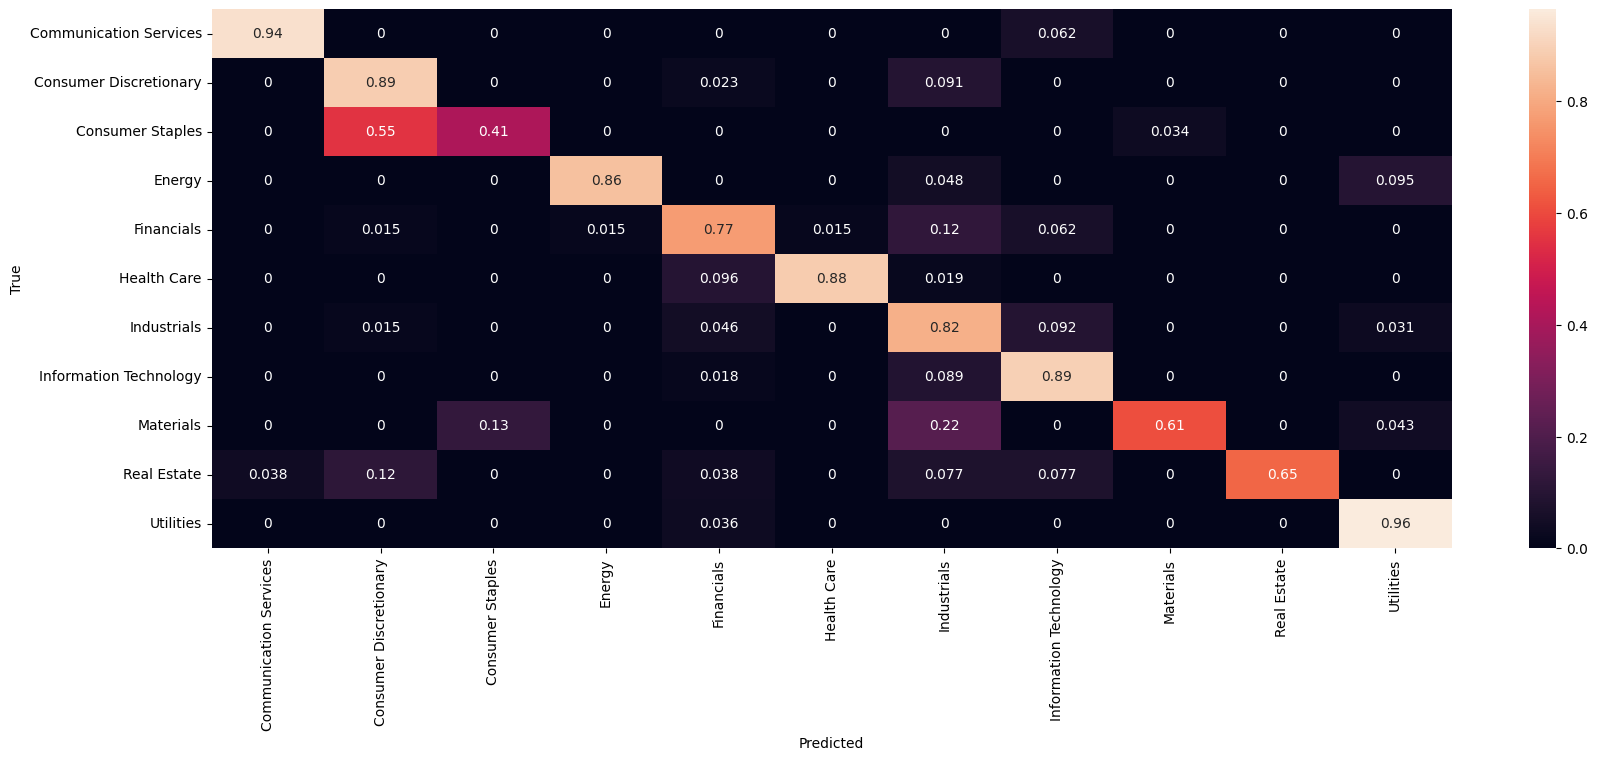

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


cm = tf.math.confusion_matrix(test_labels, pred_output)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=labels,
    yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")

# 7. Conclusion
Consumer Staples sector confused with Consumer Discretionary